In [1]:
# !pip install parcels
# !pip install plasticparcels

In [2]:
import copernicusmarine

In [3]:
#copernicusmarine.login()

In [4]:
# Library imports
from datetime import datetime, timedelta
import xarray as xr
import numpy as np

# parcels and plasticparcels imports
import plasticparcels as pp
import parcels
from parcels.tools.converters import Geographic, GeographicPolar
from parcels import StatusCode


# Plotting imports
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [5]:
# Make a copernicus settings dictionary
settings_file = 'copernicus_marine.json'
settings = pp.utils.load_settings(settings_file)

In [6]:
# # Load the model settings
# settings_file = 'docs/examples/example_Italy_coast_settings.json'
# settings = pp.utils.load_settings(settings_file)

# # Set ocean model indices
# settings['ocean']['indices'] = {'lon':range(3300, 4000), 'lat':range(1850, 2400), 'depth':range(0,2)}

In [7]:
# # Download the mask and release data
#settings = pp.utils.download_plasticparcels_dataset('NEMO0083', settings, 'input_data')


In [8]:
# Create the simulation settings
settings['simulation'] = {
    'startdate': datetime.strptime('2024-01-01-00:00:00', '%Y-%m-%d-%H:%M:%S'), # Start date of simulation
    'runtime': timedelta(days=60),        # Runtime of simulation
    'outputdt': timedelta(hours=12),      # Timestep of output
    'dt': timedelta(minutes=20),          # Timestep of advection
    'boundingbox': [-10.0, 40.0, 30.0, 45.0],  # Bounding box of simulation [lonmin, lonmax, latmin, latmax]}
    'depth_range': [0, 200],               # Depth range of simulation [depthmin, depthmax] in meters
}




In [9]:
def make_dataset_nopart(data_request):
    ds = copernicusmarine.open_dataset(
            dataset_id=data_request['dataset_id'],
            minimum_longitude=min(data_request['longitude']),
            maximum_longitude=max(data_request['longitude']),
            minimum_latitude=min(data_request['latitude']),
            maximum_latitude=max(data_request['latitude']),
            variables=data_request['variables'],
            start_datetime=data_request['time'][0],
            end_datetime=data_request['time'][1],
            minimum_depth=data_request['depth'][0],
            maximum_depth=data_request['depth'][1]
        )
    return ds

In [10]:
def copernicus_marine_ocean_fieldset(settings):
    """Create a Copernicus Marine ocean fieldset for PlasticParcels.

    Parameters
    ----------
    settings : dict
        Dictionary containing the model settings.
    """
    # Create the ocean data request
    ocean_dict = settings['ocean']
    ds_dict = {}
    for key in ocean_dict['variables'].keys():
        data_request = {
            'dataset_id': ocean_dict['dataset_id'][key],
            'longitude': settings['simulation']['boundingbox'][:2],
            'latitude': settings['simulation']['boundingbox'][2:],
            'depth': settings['simulation']['depth_range'],
            'variables': [ocean_dict['variables'][key]],
            'time': [settings['simulation']['startdate'],
                     settings['simulation']['startdate'] + settings['simulation']['runtime']]
        }
        ds = make_dataset_nopart(data_request)
        ds_dict[key] = ds
    
    # Create the hydrodynamic fieldset:
    ds_ocean = []
    for key in settings['ocean']['variables'].keys():
        ds_ocean.append(ds_dict[key])
    ds_ocean = xr.merge(ds_ocean)

    fieldset = parcels.FieldSet.from_xarray_dataset(ds_ocean,settings['ocean']['variables'], settings['ocean']['dimensions'], mesh='spherical')

    # Add in bathymetry
    data_request = {
            'dataset_id': settings['bathymetry']['dataset_id']['bathymetry'],
            'longitude': settings['simulation']['boundingbox'][:2],
            'latitude': settings['simulation']['boundingbox'][2:],
            'depth': settings['simulation']['depth_range'],
            'variables': [settings['bathymetry']['variables']['bathymetry']],
            'time': [settings['simulation']['startdate'],
                     settings['simulation']['startdate'] + settings['simulation']['runtime']]
        }
    ds_bathymetry = make_dataset_nopart(data_request)
    fieldset_bathymetry = parcels.FieldSet.from_xarray_dataset(ds_bathymetry,settings['bathymetry']['variables'], settings['bathymetry']['dimensions'], mesh='spherical')
    fieldset.add_field(fieldset_bathymetry.bathymetry)

    # Add in bgc fields
    if settings['use_biofouling']:
        bgc_dict = settings['bgc']
        ds_dict = {}
        for key in bgc_dict['variables'].keys():
            data_request = {
                'dataset_id': bgc_dict['dataset_id'][key],
                'longitude': settings['simulation']['boundingbox'][:2],
                'latitude': settings['simulation']['boundingbox'][2:],
                'depth': settings['simulation']['depth_range'],
                'variables': [bgc_dict['variables'][key]],
                'time': [settings['simulation']['startdate'],
                        settings['simulation']['startdate'] + settings['simulation']['runtime']]
            }
            ds = make_dataset_nopart(data_request)
            ds_dict[key] = ds

        # Create the bgc fieldset:
        ds_bgc = []
        for key in settings['bgc']['variables'].keys():
            ds_bgc.append(ds_dict[key])
        ds_bgc = xr.merge(ds_bgc)
        fieldset_bgc = parcels.FieldSet.from_xarray_dataset(ds_bgc,settings['bgc']['variables'], settings['bgc']['dimensions'], mesh='spherical')
        for field in fieldset_bgc.get_fields():
            fieldset.add_field(field)
        
        for key in settings['bgc']['constants']:
            fieldset.add_constant(key, settings['bgc']['constants'][key])

    # Add in stokes
    if settings['use_stokes']:
        stokes_dict = settings['stokes']
        ds_dict = {}
        for key in stokes_dict['variables'].keys():
            data_request = {
                'dataset_id': stokes_dict['dataset_id'][key],
                'longitude': settings['simulation']['boundingbox'][:2],
                'latitude': settings['simulation']['boundingbox'][2:],
                'depth': settings['simulation']['depth_range'],
                'variables': [stokes_dict['variables'][key]],
                'time': [settings['simulation']['startdate'],
                         settings['simulation']['startdate'] + settings['simulation']['runtime']]
            }
            ds = make_dataset_nopart(data_request)
            ds_dict[key] = ds
        # Create the stokes fieldset:
        ds_stokes = []
        for key in settings['stokes']['variables'].keys():
            ds_stokes.append(ds_dict[key])
        ds_stokes = xr.merge(ds_stokes)
        fieldset_stokes = parcels.FieldSet.from_xarray_dataset(ds_stokes,settings['stokes']['variables'], settings['stokes']['dimensions'], mesh='spherical')
        fieldset_stokes.Stokes_U.units = GeographicPolar()
        fieldset_stokes.Stokes_V.units = Geographic()
        for field in fieldset_stokes.get_fields():
            fieldset.add_field(field)

    return fieldset




In [11]:
fieldset = copernicus_marine_ocean_fieldset(settings)

INFO - 2025-11-20T21:41:35Z - Selected dataset version: "202406"
INFO - 2025-11-20T21:41:35Z - Selected dataset part: "default"
WARNING - 2025-11-20T21:41:36Z - Some of your subset selection [0, 200] for the depth dimension exceed the dataset coordinates [0.49402499198913574, 5727.9169921875]
INFO - 2025-11-20T21:41:38Z - Selected dataset version: "202406"
INFO - 2025-11-20T21:41:38Z - Selected dataset part: "default"
WARNING - 2025-11-20T21:41:39Z - Some of your subset selection [0, 200] for the depth dimension exceed the dataset coordinates [0.49402499198913574, 5727.9169921875]
INFO - 2025-11-20T21:41:40Z - Selected dataset version: "202406"
INFO - 2025-11-20T21:41:40Z - Selected dataset part: "default"
WARNING - 2025-11-20T21:41:42Z - Some of your subset selection [0, 200] for the depth dimension exceed the dataset coordinates [0.49402499198913574, 5727.9169921875]
INFO - 2025-11-20T21:41:43Z - Selected dataset version: "202406"
INFO - 2025-11-20T21:41:43Z - Selected dataset part: 

In [12]:
fieldset.get_fields()

In [21]:
fieldset.add_constant('use_3D', settings['use_3D'])
fieldset.add_constant('use_biofouling', settings['use_biofouling'])
fieldset.add_constant('use_wind', settings['use_wind'])
fieldset.add_constant('use_stokes', settings['use_stokes'])
fieldset.add_constant('use_mixing', settings['use_mixing'])
fieldset.add_constant('G', 9.81)  # gravitational acceleration in m/s^2
fieldset.add_constant('z_start', 0.5)  # starting depth in meters

In [31]:
# Create the particle release settings
settings['release'] = {
    'initialisation_type': 'fisheries',
    'country': 'Italy',
}

In [32]:
# Create the plastic type settings
settings['plastictype'] = {
    'wind_coefficient' : 0.01,  # Percentage of wind to apply to particles
    'plastic_diameter' : 0.001, # Plastic particle diameter (m)
    'plastic_density' : 1030.,  # Plastic particle density (kg/m^3)
}

In [33]:
# Create the particleset
pset = pp.constructors.create_particleset_from_map(fieldset, settings)

# Create the applicable kernels to the plastic particles
kernels = pp.constructors.create_kernel(fieldset)

In [34]:
runtime = settings['simulation']['runtime']
dt = settings['simulation']['dt']
outputdt = settings['simulation']['outputdt']

In [ ]:
# Create the particle file where output will be stored
pfile = pp.ParticleFile('example_copernicusmarine.zarr', pset, settings=settings, outputdt=outputdt)
# MIKE TODO: coastal might not match this model coast, it isn't the c-grid, so CHECK!

In [36]:
# Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt, output_file=pfile)

INFO: Output files are stored in example_copernicusmarine.zarr.
100%|██████████| 5184000.0/5184000.0 [04:57<00:00, 17439.23it/s]


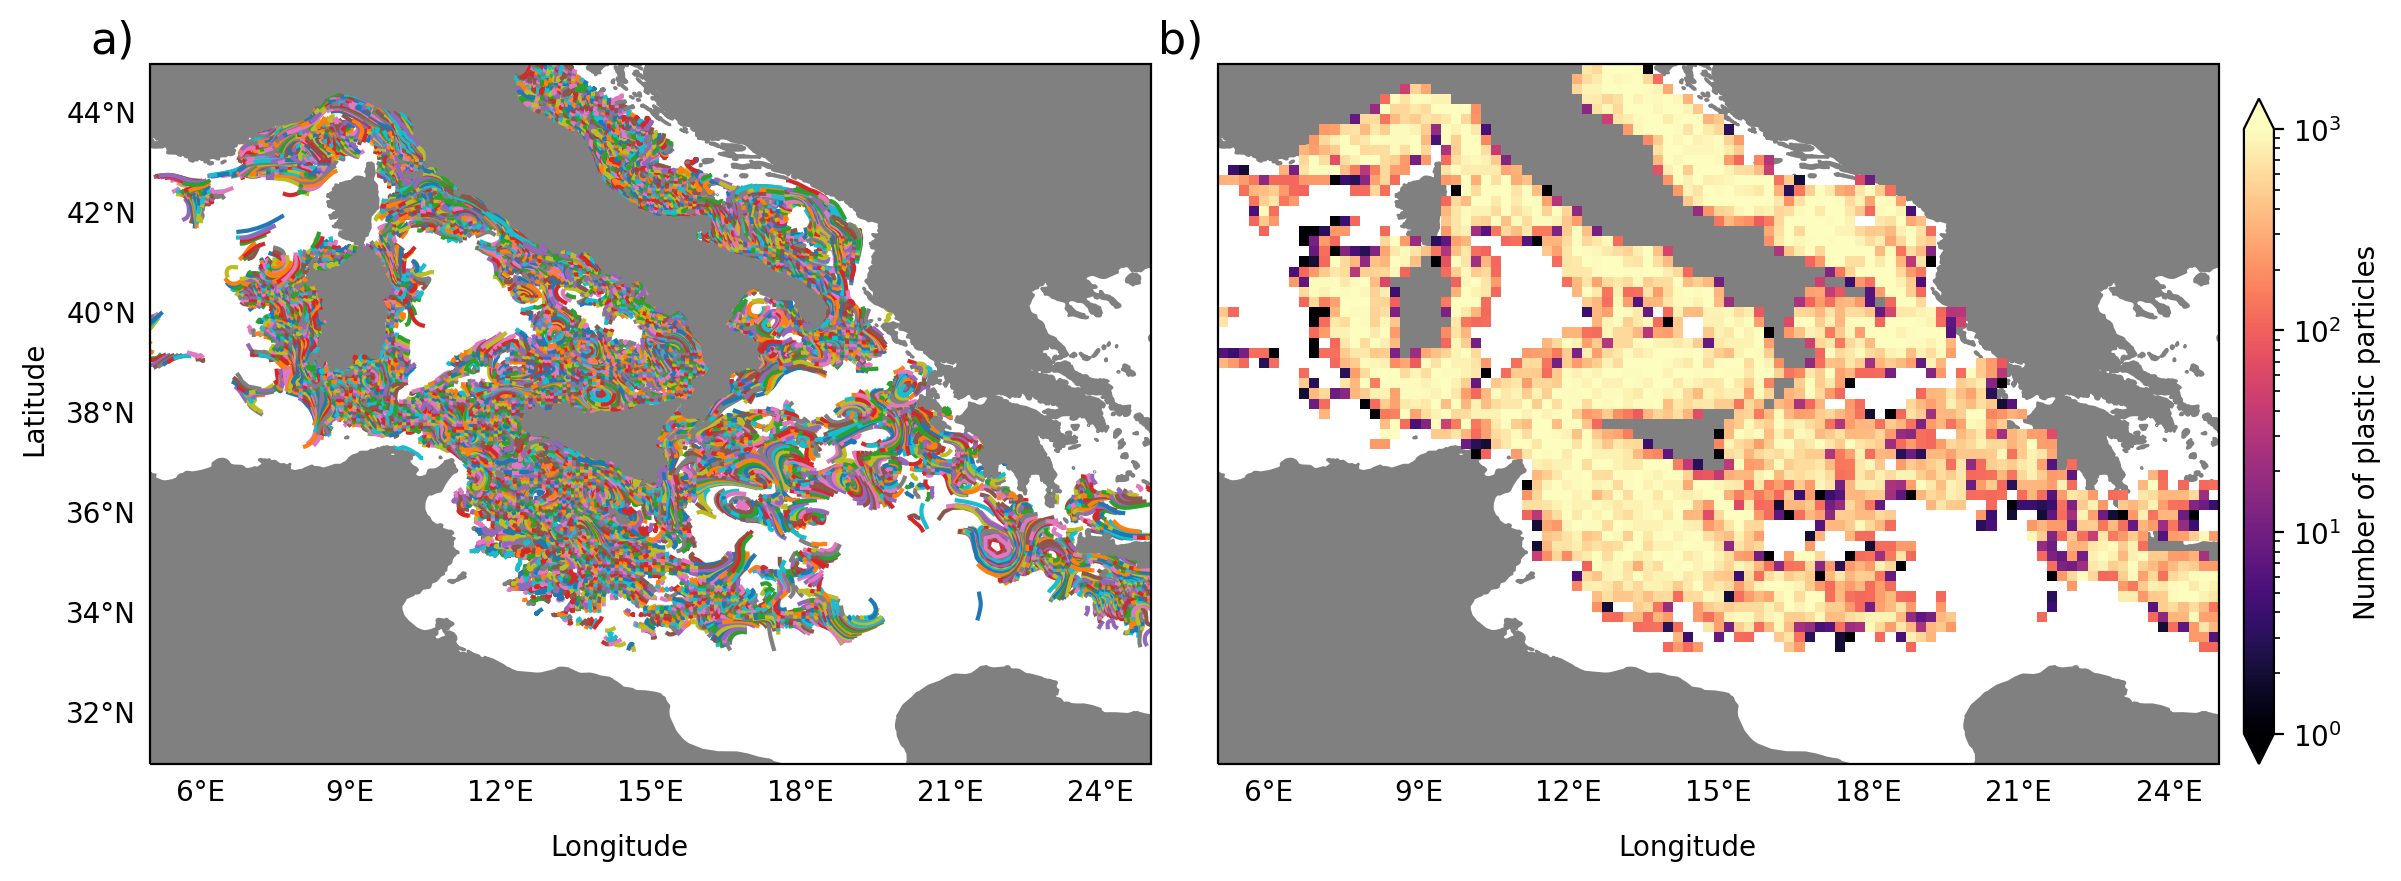

In [37]:
# Load the ParticleFile
ds = xr.open_zarr('example_copernicusmarine.zarr')

# Settings for the concentration map
bins = (np.linspace(5,25,100),np.linspace(31,45,70))
i = -1 # Use final timestep

# Create the figure object
plt.figure(figsize=(14,5), dpi=200)
gs = gridspec.GridSpec(1, 3, width_ratios=[30,30,1], wspace=0.1)
cb_axes_position = [1.025, 0.0, 0.03, 0.95]

# Plot the trajectories
ax = plt.subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree(), zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, color='grey')

ax.set_extent([5,25,31,45], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([6,9,12,15,18,21,24])

ax.text(-0.06, 1.015, 'a)', transform=ax.transAxes, size=16)
ax.text(-0.13, 0.45, 'Latitude', transform=ax.transAxes, size=10, rotation=90)
ax.text(0.4, -0.13, 'Longitude', transform=ax.transAxes, size=10)

# Plot the Concentration map
ax = plt.subplot(gs[0,1], projection=ccrs.PlateCarree())
cb = ax.hist2d(ds['lon'][:,:i].values.flatten(),ds['lat'][:,:i].values.flatten(), bins=bins,norm=LogNorm(vmin=1, vmax=1000), cmap=plt.cm.magma, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=0, color='grey')

cbar_ax = ax.inset_axes(cb_axes_position)
cbar = plt.colorbar(cb[3], cax=cbar_ax, extend='both')
cbar.set_label('Number of plastic particles', fontsize=10)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([6,9,12,15,18,21,24])

ax.text(-0.06, 1.015, 'b)', transform=ax.transAxes, size=16)
ax.text(0.4, -0.13, 'Longitude', transform=ax.transAxes, size=10)

plt.show()